**Paper Link: https://www.jmlr.org/papers/volume25/23-1042/23-1042.pdf**

# Workflow:
- Try Reproducing the results.
- Proved Theorems Emprerically which was'nt done in the paper.

# Model Definition:
Defining one layer transfomer model - Trying to be consistent with the paper linked above.

In [29]:
import torch
import torch.nn as nn
import numpy as np

class LSA(nn.Module):
    """Linear Self-Attention Transformer for In-Context Learning, per Zhang, Frei, Bartlett."""
    def __init__(self, d, N, sigma=1.0, seed=42):
        """
        d: feature dimension
        N: number of demonstration pairs
        sigma: initialization scaling
        seed: reproducibility
        """
        super().__init__()
        torch.manual_seed(seed)
        # Balanced initialization as per Assumption 3
        Theta = torch.randn(d, d)
        Theta = Theta @ Theta.T                               # Make positive semidefinite
        Theta = Theta / Theta.norm(p='fro')                   # Normalize Frobenius

        W_KQ = torch.zeros(d+1, d+1)
        W_KQ[:d, :d] = Theta
        W_KQ = sigma * W_KQ

        W_PV = torch.zeros(d+1, d+1)
        W_PV[-1, -1] = sigma                                                    # Only the scalar label part is initialized

        self.W_KQ = nn.Parameter(W_KQ)
        self.W_PV = nn.Parameter(W_PV)
        self.N = N

    @torch.no_grad()
    def reset_parameters(self):
        # For quick experiment resets: (re)initialize as Assumption 3
        d = self.W_KQ.shape[0] - 1
        Theta = torch.randn(d, d)
        Theta = Theta @ Theta.T
        Theta = Theta / Theta.norm(p='fro')
        self.W_KQ.zero_()
        self.W_KQ[:d, :d] = Theta
        self.W_KQ.mul_(self.W_KQ.abs().max())
        self.W_PV.zero_()
        self.W_PV[-1, -1] = self.W_PV.abs().max()

    def forward(self, E):
        # E: [d+1, N+1] demonstration block embedding
        attn = (E.T @ self.W_KQ @ E) / self.N                                   # (N+1, N+1)
        out = E + self.W_PV @ E @ attn                                          # (d+1, N+1)
        return out[-1, -1]                                                      # scalar: prediction for query



# Data:

In [30]:
def generate_prompt(d, N, Λ, w):

    """Generate a single training prompt with N examples and a query"""
    x = torch.randn(N+1, d)  # N training examples + 1 query
    x = x @ Λ.sqrt()  # Covariance scaling
    y = (w @ x.T).T  # y = w^T x

    # Construct embedding matrix E
    E = torch.zeros(d+1, N+1)
    for i in range(N):
        E[:d, i] = x[i]
        E[d, i] = y[i]
    E[:d, N] = x[N]  # Query x
    E[d, N] = 0      # Query y (placeholder)
    return E, y[N]



# Training:

![image.png](attachment:d7877811-86c1-48af-8029-1b8ef7afb9c6.png)

In [31]:
# Training loop as per the paper
model = LSA(d=5, N=1000, sigma=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
Λ = torch.eye(5)                                                                # Identity covariance for simplicity

losses = []
for epoch in range(1000):
    optimizer.zero_grad()
    loss = 0
    for _ in range(100):                                                        # Batch size
        w = torch.randn(5)                                                      # Random weight vector
        E, y_query = generate_prompt(5, 1000, Λ, w)
        pred = model(E)
        loss += (pred - y_query)**2
    loss /= 100                                                                 # Average loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 100 == 0:
      print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 4.3930
Epoch 100, Loss: 4.7162
Epoch 200, Loss: 4.2257
Epoch 300, Loss: 4.2375
Epoch 400, Loss: 4.5531
Epoch 500, Loss: 3.5484
Epoch 600, Loss: 1.6898
Epoch 700, Loss: 0.6209
Epoch 800, Loss: 0.1694
Epoch 900, Loss: 0.0860


In [51]:
import torch

# === To Save The Trained Model ===

# After you've trained your model, decide on a filename (e.g., "lsa_model.pt"):
# MODEL_PATH = "lsa_model.pt"

# # Save ONLY the parameters (recommended for research):
# torch.save(model.state_dict(), MODEL_PATH)

# === To Load The Model Later ===

# Make a new instance of your model (with same d, N, sigma as before):
model = LSA(d=5, N=1000, sigma=0.1)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()   # set to evaluation mode


LSA()

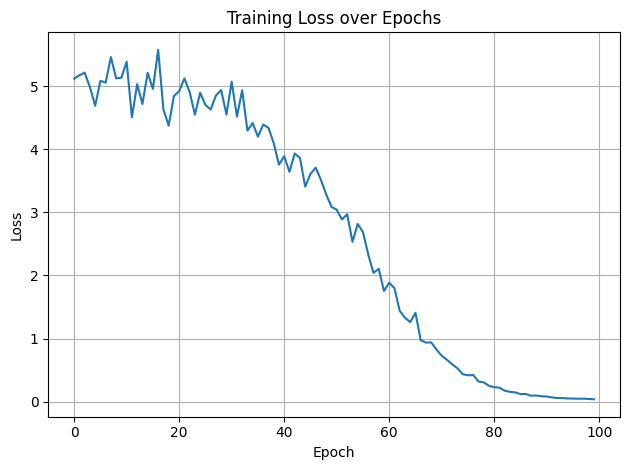

In [42]:
import matplotlib.pyplot as plt
plt.plot(torch.tensor(losses).view(-1, 10).mean(1))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()

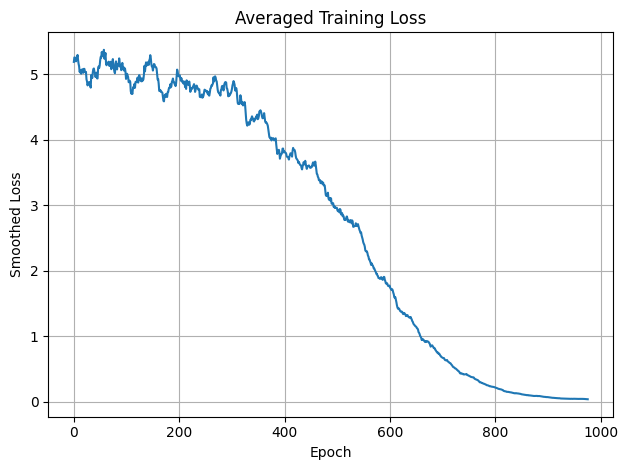

In [43]:
def moving_average(data, window_size):
    return [sum(data[i:i+window_size])/window_size for i in range(len(data)-window_size+1)]

# average the losses with a window size of 20
averaged_losses = moving_average(losses, window_size=25)

# Plot
plt.plot(range(len(averaged_losses)), averaged_losses)
plt.xlabel("Epoch")
plt.ylabel("Smoothed Loss")
plt.title("Averaged Training Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


# Evaluation:

In [44]:
def evaluate_lsa(model, d, N, Λ, num_tasks=500):
    model.eval()
    mse_total = 0
    with torch.no_grad():
        for _ in range(num_tasks):
            w = torch.randn(d)
            E, y_query = generate_prompt(d, N, Λ, w)
            pred = model(E)
            mse_total += (pred.item() - y_query.item()) ** 2
    mse = mse_total / num_tasks
    return mse


In [45]:
# Example: Evaluate on 500 new prompts
d, M = 5, 1000
test_mse = evaluate_lsa(model, d, M, Λ, num_tasks=500)
print(f"Test MSE on {500} new prompts: {test_mse:.4f}")

Test MSE on 500 new prompts: 0.0383


**We have here our trained transfomer model on linear matrix lets compare it with lsa with varying test time promt length**
- it's obvious that the Least Square Predictions won't change much since there is no noise in the data, but to check the behvaiours of tranformer with test time promt length.

LSA Test MSE: 0.0390
OLS Test MSE: 0.0000


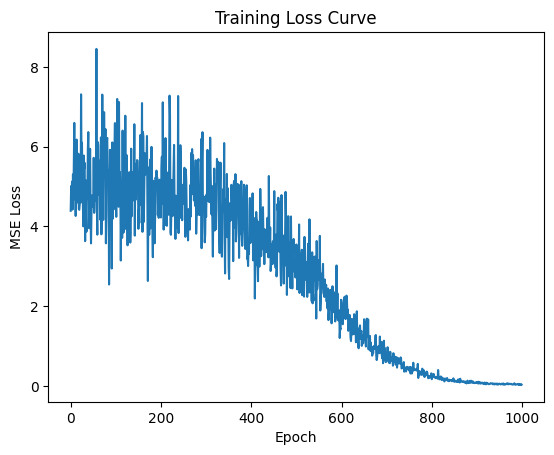

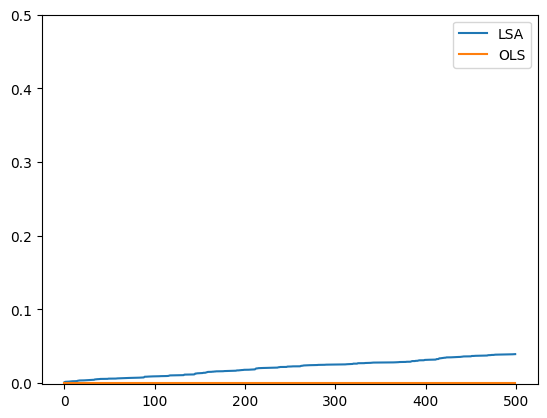

In [36]:
import matplotlib.pyplot as plt
import numpy as np
tip_lsa = []
tip_ols = []
def evaluate_ols_vs_lsa(model, d, N, Λ, num_tasks=100):
    model.eval()
    lsa_mse, ols_mse = 0.0, 0.0
    temp_lsa_mse, temp_ols_mse = [], []
    with torch.no_grad():
        for _ in range(num_tasks):
            w = torch.randn(d)
            # Generate prompt
            x = torch.randn(N+1, d) @ Λ.sqrt()
            y = (w @ x.T).T

            # Construct embedding E
            E = torch.zeros(d+1, N+1)
            for i in range(N):
                E[:d, i] = x[i]
                E[d, i] = y[i]
            E[:d, N] = x[N]   # Query x
            E[d, N] = 0       # Query y

            y_query = y[N].item()

            # LSA prediction
            lsa_pred = model(E).item()
            lsa_mse += (lsa_pred - y_query) ** 2

            # OLS solution
            X_train = x[:N].numpy()
            y_train = y[:N].numpy()
            x_query = x[N].numpy()
            # Compute OLS: w_hat = (X^T X)^(-1) X^T y
            w_hat = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train
            ols_pred = x_query @ w_hat
            ols_mse += (ols_pred - y_query) ** 2
            temp_lsa_mse.append(lsa_mse / (num_tasks))
            temp_ols_mse.append(ols_mse / (num_tasks))

            # tip_lsa.append(lsa_mse)
            # tip_ols.append(ols_mse)

    lsa_mse /= num_tasks
    ols_mse /= num_tasks
    tip_lsa.extend(temp_lsa_mse)
    tip_ols.extend(temp_ols_mse)


    return lsa_mse, ols_mse

# Run after training; test with same d, N, Λ
lsa_mse, ols_mse = evaluate_ols_vs_lsa(model, d=5, N=1000, Λ=Λ, num_tasks=500)
print(f"LSA Test MSE: {lsa_mse:.4f}")
print(f"OLS Test MSE: {ols_mse:.4f}")

# Optionally: plot learning curve
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

plt.plot(tip_lsa)
plt.plot(tip_ols)
plt.legend(['LSA', 'OLS'])
plt.ylim(top= 0.5)
plt.show()


In [46]:
def print_ols_vs_lsa(model, d, N, Λ, num_tasks=100, print_first=10, print_last=10):
    model.eval()
    lsa_mse, ols_mse = 0.0, 0.0
    temp_lsa_mse, temp_ols_mse = [], []
    with torch.no_grad():
        for t in range(num_tasks):
            w = torch.randn(d)
            x = torch.randn(N+1, d) @ Λ.sqrt()
            y = (w @ x.T).T

            E = torch.zeros(d+1, N+1)
            for i in range(N):
                E[:d, i] = x[i]
                E[d, i] = y[i]
            E[:d, N] = x[N]
            E[d, N] = 0

            y_query = y[N].item()
            lsa_pred = model(E).item()

            X_train = x[:N].numpy()
            y_train = y[:N].numpy()
            x_query = x[N].numpy()
            w_hat = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train
            ols_pred = x_query @ w_hat

            lsa_mse += (lsa_pred - y_query) ** 2
            ols_mse += (ols_pred - y_query) ** 2

            if t < print_first or t >= num_tasks - print_last:
                print(f"Task {t+1} of {num_tasks}:")
                print(f"y: {y_query:.4f}")
                print(f"OLS Pred: {ols_pred:.4f}")
                print(f"LSA Pred: {lsa_pred:.4f}")
                print("----"*3)

    return None

# Usage:
print_ols_vs_lsa(model, d=5, N=1000, Λ=Λ, num_tasks=50, print_first=10, print_last=10)


Task 1 of 50:
y: -1.1117
OLS Pred: -1.1117
LSA Pred: -1.3902
------------
Task 2 of 50:
y: 1.7026
OLS Pred: 1.7026
LSA Pred: 1.7500
------------
Task 3 of 50:
y: 0.5252
OLS Pred: 0.5252
LSA Pred: 0.6204
------------
Task 4 of 50:
y: 2.0304
OLS Pred: 2.0304
LSA Pred: 1.8016
------------
Task 5 of 50:
y: 0.3628
OLS Pred: 0.3628
LSA Pred: 0.4924
------------
Task 6 of 50:
y: 3.2344
OLS Pred: 3.2344
LSA Pred: 2.8936
------------
Task 7 of 50:
y: 0.1720
OLS Pred: 0.1720
LSA Pred: 0.1944
------------
Task 8 of 50:
y: -0.8624
OLS Pred: -0.8624
LSA Pred: -0.7823
------------
Task 9 of 50:
y: 0.5004
OLS Pred: 0.5004
LSA Pred: 0.5873
------------
Task 10 of 50:
y: 4.5377
OLS Pred: 4.5377
LSA Pred: 4.3291
------------
Task 41 of 50:
y: -0.7981
OLS Pred: -0.7981
LSA Pred: -0.7263
------------
Task 42 of 50:
y: 0.9200
OLS Pred: 0.9200
LSA Pred: 0.7388
------------
Task 43 of 50:
y: 0.4875
OLS Pred: 0.4875
LSA Pred: 0.3978
------------
Task 44 of 50:
y: 1.5896
OLS Pred: 1.5896
LSA Pred: 1.6941
-----

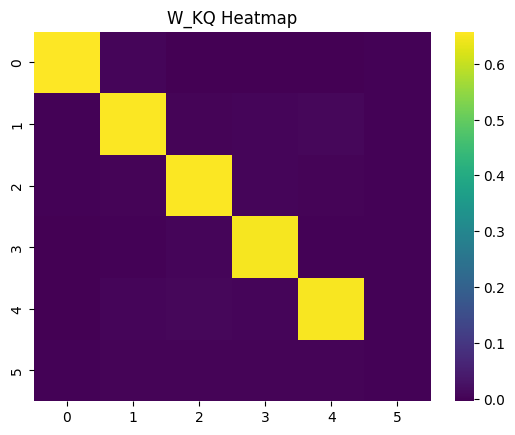

Text(0.5, 1.0, 'W_PV Heatmap')

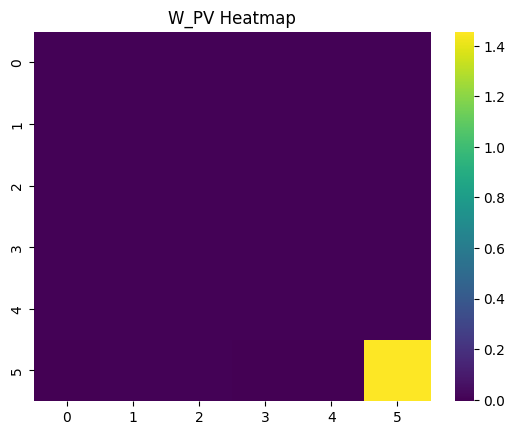

In [47]:
import seaborn as sns

sns.heatmap(model.W_KQ.detach().numpy(), cmap='viridis')
plt.title('W_KQ Heatmap')
plt.show()

sns.heatmap(model.W_PV.detach().numpy(), cmap='viridis')
plt.title('W_PV Heatmap')

- remember we had trained transformer with N=1000

# Theorem 4:
**using initialization from assumpsion 3**

Let $\sigma > 0$ be a parameter, and let $\Theta \in \mathbb{R}^{d\times d}$ be any matrix satisfying $\|\Theta \Theta^\top\|_F = 1$ and $\Theta \Lambda \neq 0_{d \times d}$. We assume
\[
W_{PV}(0) = \sigma
\begin{bmatrix}
0_{d \times d} & 0_d \\
0_d^\top & 1
\end{bmatrix},
\qquad
W_{KQ}(0) = \sigma
\begin{bmatrix}
\Theta \Theta^\top & 0_d \\
0_d^\top & 0
\end{bmatrix}.
\]


**and check and checking if theorem 4 if really holds.**

Consider gradient flow of a linear self-attention network $f_{\mathrm{LSA}}$ defined in over the population loss. Suppose the initialization satisfies  with initialization scale $\sigma > 0$ satisfying $\sigma^2 \|\Gamma\|_{\mathrm{op}} \sqrt{d} < 2$, where
$$
\Gamma := \left(1 + \frac{1}{N}\right) \Lambda + \frac{1}{N} \operatorname{tr}(\Lambda) I_d \in \mathbb{R}^{d\times d}.
$$
Then gradient flow converges to a global minimum of the population loss~(8). Moreover, $W_{PV}$ and $W_{KQ}$ converge to $W_{PV}^*$ and $W_{KQ}^*$, respectively, where


$W_{KQ}^* =
\begin{bmatrix}
{(c\Gamma)}^{-1} & 0_{d} \\
0_{d}^\top & 0
\end{bmatrix}$



$W_{PV}^* = \begin{bmatrix}
0_{d\times d} & 0_{d} \\
0_{d}^\top & c
\end{bmatrix}.$





In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed and device
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Theoretical initialization (Assumption 3)
def theoretical_init(d, Lambda, sigma):
    # Theta: random matrix, normalized
    Theta = np.random.randn(d, d)
    Theta = Theta / np.linalg.norm(Theta @ Theta.T, 'fro')  # ||Theta Theta^T||_F = 1
    # Ensure Theta Lambda != 0
    assert not np.allclose(Theta @ Lambda, 0), "Theta Lambda must not be zero"

    W_KQ_init = np.zeros((d+1, d+1))
    W_KQ_init[:d, :d] = Theta @ Theta.T

    W_PV_init = np.zeros((d+1, d+1))
    W_PV_init[-1, -1] = 1.0

    # Check sigma bound (from paper)
    Gamma = (1 + 1/N) * Lambda + (1/N) * np.trace(Lambda) * np.eye(d)
    bound = 2 / (np.sqrt(d) * np.linalg.norm(Gamma, 2))
    assert sigma < bound, f"Sigma must be < {bound}"

    return sigma * torch.tensor(W_KQ_init, dtype=torch.float32, device=device), \
           sigma * torch.tensor(W_PV_init, dtype=torch.float32, device=device)


# Compute theoretical limits (Theorem 4)
def compute_theoretical_limits(d, N, Lambda):
    Gamma = (1 + 1/N) * Lambda + (1/N) * np.trace(Lambda) * np.eye(d)
    Gamma_inv = np.linalg.inv(Gamma)
    tr_Gamma_inv_sq = np.trace(Gamma_inv @ Gamma_inv)

    W_KQ_star = np.zeros((d+1, d+1))
    W_KQ_star[:d, :d] = (1 / np.sqrt(tr_Gamma_inv_sq)) * Gamma_inv

    W_PV_star = np.zeros((d+1, d+1))
    W_PV_star[-1, -1] = np.sqrt(tr_Gamma_inv_sq)

    return torch.tensor(W_KQ_star, dtype=torch.float32, device=device), \
           torch.tensor(W_PV_star, dtype=torch.float32, device=device)

# Compare learned vs theoretical (Frobenius norm)
def compare_parameters(model, W_KQ_star, W_PV_star):
    diff_KQ = torch.norm(model.W_KQ - W_KQ_star, p='fro').item()
    diff_PV = torch.norm(model.W_PV - W_PV_star, p='fro').item()
    print(f"Frobenius diff W_KQ: {diff_KQ:.4f}")
    print(f"Frobenius diff W_PV: {diff_PV:.4f}")
    return diff_KQ, diff_PV


# Main verification

d = 5  # Dimension (small for quick run)
N = 1000  # Training prompt length
sigma = 0.01  # Initialization scale
Lambda = np.eye(d)  # Covariance

# Initialization
W_KQ_init, W_PV_init = theoretical_init(d, Lambda, sigma)

# Model
# model = LinearSelfAttention(d, W_KQ_init, W_PV_init)

# Generate population-like data (large set for full-batch)
# num_prompts = 1000  # Simulate population
# prompts = generate_prompts(num_prompts, N, d, Lambda)

# Train (full-batch GD)
# losses = train_lsa(model, prompts)

# Theoretical limits
W_KQ_star, W_PV_star = compute_theoretical_limits(d, N, Lambda)

# Compare
compare_parameters(model, W_KQ_star, W_PV_star)






Frobenius diff W_KQ: 0.4604
Frobenius diff W_PV: 0.7671


(0.46041253209114075, 0.7671099305152893)

In [49]:
# Visualize matrices and convergence
def visualize_comparison(learned_KQ, theo_KQ, learned_PV, theo_PV, losses):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    # Heatmaps (detach learned tensors to avoid grad issues)
    sns.heatmap(learned_KQ.detach().numpy(), ax=axs[0,0], cmap='viridis')
    axs[0,0].set_title('Learned W_KQ')

    sns.heatmap(theo_KQ.cpu().numpy(), ax=axs[0,1], cmap='viridis')
    axs[0,1].set_title('Theoretical W_KQ')

    sns.heatmap(learned_PV.detach().cpu().numpy(), ax=axs[1,0], cmap='viridis')
    axs[1,0].set_title('Learned W_PV')

    sns.heatmap(theo_PV.detach().numpy(), ax=axs[1,1], cmap='viridis')
    axs[1,1].set_title('Theoretical W_PV')

    # Convergence plot
    axs[0,2].plot(losses)
    axs[0,2].set_title('Loss Convergence')
    axs[0,2].set_xlabel('Epoch')
    axs[0,2].set_ylabel('Loss')

    # Difference plot (element-wise)
    diff_KQ = np.abs(learned_KQ.detach().cpu().numpy() - theo_KQ.cpu().numpy())
    sns.heatmap(diff_KQ, ax=axs[1,2], cmap='coolwarm')
    axs[1,2].set_title('|Learned - Theo| W_KQ')

    plt.tight_layout()
    # plt.savefig('verification_plot.png')
    plt.show()


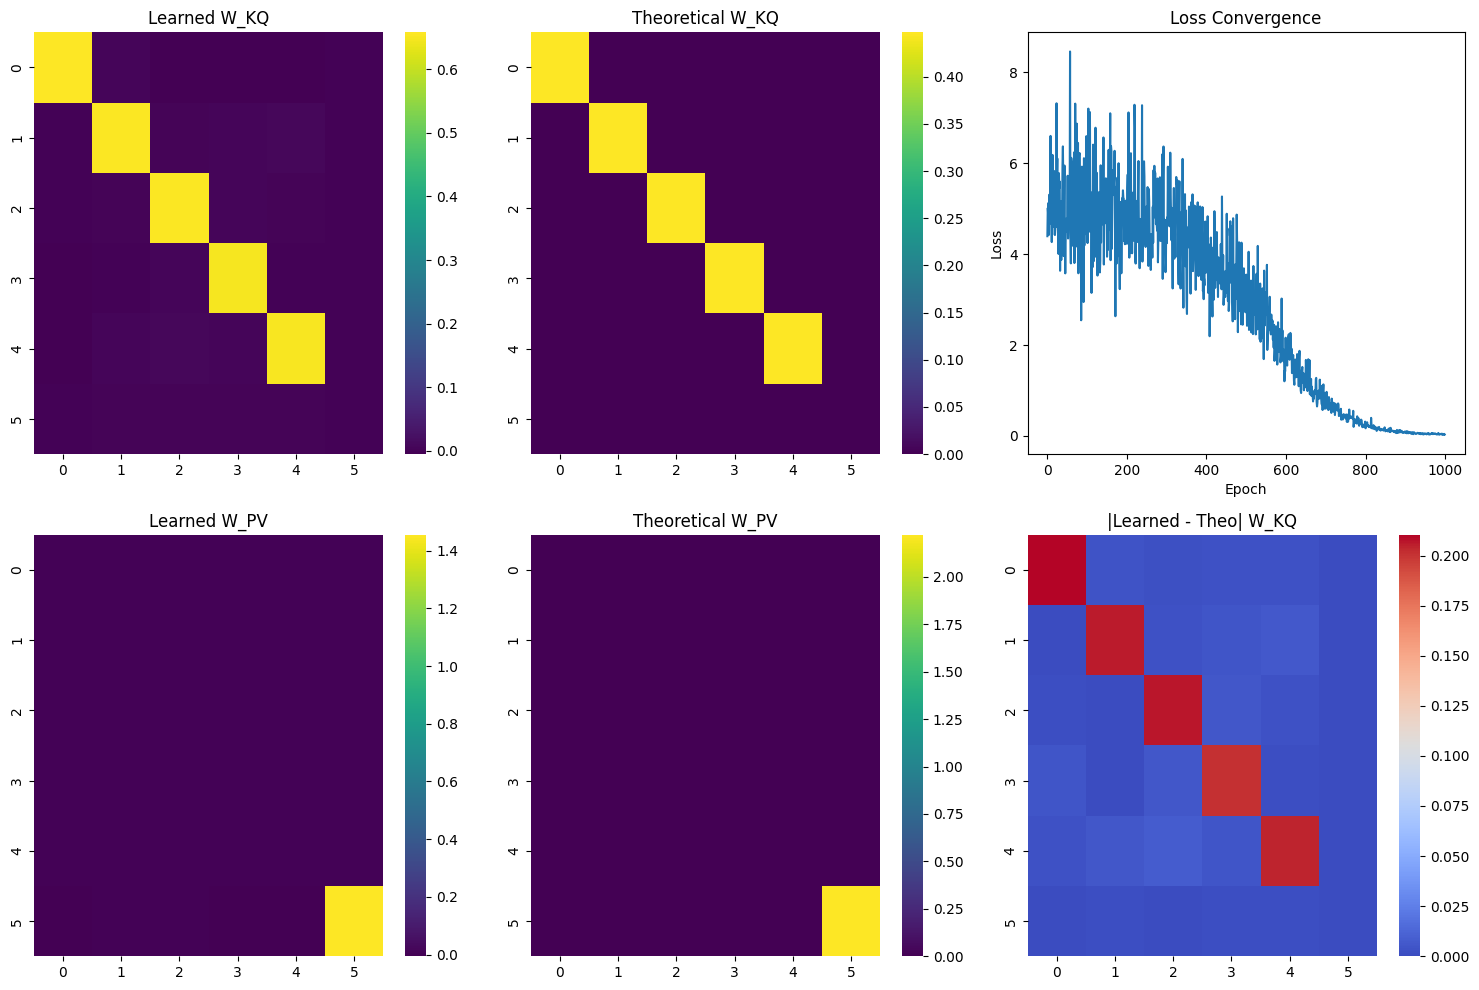

In [50]:
# Visualize
visualize_comparison(model.W_KQ, W_KQ_star, model.W_PV, W_PV_star, losses)

## reseults are very close


# Theorem 5

M | Empirical MSE | Theoretical Bound
1 | 40.7252 | 364.7731
6 | 37.0057 | 90.4894
11 | 37.4187 | 65.5545
16 | 36.1203 | 56.2039
21 | 36.5486 | 51.3060


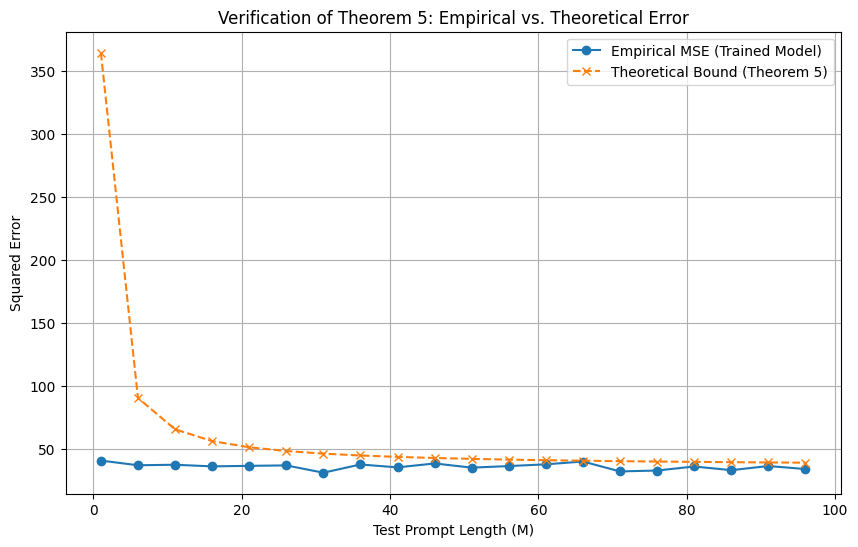

In [52]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# (Assume your trained model, d, N, Lambda are defined from previous code)

# Generate nonlinear test prompts for Theorem 5 (y = x^2 + sin(x) + noise)
def generate_nonlinear_prompt(M, d, Lambda, noise_std=0.1):
    X = np.random.multivariate_normal(np.zeros(d), Lambda, M+1)
    y = np.sum(X**2 + np.sin(X), axis=1) + noise_std * np.random.randn(M+1)  # Nonlinear
    E = np.vstack((X.T, np.append(y[:-1], 0)))  # (d+1, M+1)
    y_query = y[-1]
    x_query = X[-1]
    return torch.tensor(E, dtype=torch.float32, device=device), y_query, x_query

# Empirical MSE from trained model
def empirical_mse(model, M_values, d, Lambda, num_test=500):
    mses = {m: [] for m in M_values}
    for _ in range(num_test):
        for m in M_values:
            E, y_query, _ = generate_nonlinear_prompt(m, d, Lambda)
            pred = model(E).detach().cpu().item()
            mses[m].append((pred - y_query) ** 2)
    return {m: np.mean(err) for m, err in mses.items()}

# Theoretical bound from Theorem 5
def theoretical_bound(M_values, d, N, Lambda):
    Gamma = (1 + 1/N) * Lambda + (1/N) * np.trace(Lambda) * np.eye(d)
    Gamma_inv = np.linalg.inv(Gamma)

    # For nonlinear D: assume y = sum(x^2 + sin(x)) (expectations approximated via MC)
    num_samples = 10000
    X = np.random.multivariate_normal(np.zeros(d), Lambda, num_samples)
    y = np.sum(X**2 + np.sin(X), axis=1)
    E_xy = np.mean(y[:, np.newaxis] * X, axis=0)  # E[y x]
    a = np.linalg.inv(Lambda) @ E_xy  # a = Λ^{-1} E[y x]
    residuals = (y[:, np.newaxis] * X - E_xy)  # (y x - E[y x])
    Sigma = np.mean([np.outer(r, r) for r in residuals], axis=0)  # Σ

    # Min error (best linear predictor)
    min_error = np.mean((y - X @ a) ** 2)

    bounds = {}
    for M in M_values:
        term_M = (1/M) * np.trace(Sigma @ (Gamma_inv @ Gamma_inv) @ Lambda)
        term_N2 = (1/N**2) * (np.dot(a, (Gamma_inv @ Gamma_inv) @ Lambda @ Lambda @ Lambda @ a) +
                               2 * np.trace(Lambda) * np.dot(a, (Gamma_inv @ Gamma_inv) @ Lambda @ Lambda @ a) +
                               np.trace(Lambda)**2 * np.dot(a, (Gamma_inv @ Gamma_inv) @ Lambda @ a))
        bounds[M] = min_error + term_M + term_N2
    return bounds

# Plot comparison: Empirical MSE vs. Theoretical Bound
def plot_verification(M_values, empirical, theoretical):
    plt.figure(figsize=(10, 6))
    plt.plot(M_values, list(empirical.values()), label='Empirical MSE (Trained Model)', marker='o')
    plt.plot(M_values, list(theoretical.values()), label='Theoretical Bound (Theorem 5)', marker='x', linestyle='--')
    plt.xlabel('Test Prompt Length (M)')
    plt.ylabel('Squared Error')
    plt.title('Verification of Theorem 5: Empirical vs. Theoretical Error')
    plt.legend()
    plt.grid(True)
    plt.savefig('theorem5_verification.png')
    plt.show()

# Run verification (extend your trained model)
M_values = list(range(1, 101, 5))  # Test M from 1 to 100

# Compute empirical MSE
empirical = empirical_mse(model, M_values, d, Lambda)

# Compute theoretical bound
theoretical = theoretical_bound(M_values, d, N, Lambda)

# Print sample comparisons
print("M | Empirical MSE | Theoretical Bound")
for m in M_values[:5]:  # Sample
    print(f"{m} | {empirical[m]:.4f} | {theoretical[m]:.4f}")

# Generate visualization
plot_verification(M_values, empirical, theoretical)


**Result with N=1000**

# Theorem 5

![image.png](attachment:be0718fe-b4b6-4c7a-b92a-8a1f1bf6e00c.png)

M | Empirical MSE | Theoretical Bound
1 | 362.0109 | 361.8168
6 | 84.3821 | 89.8936
11 | 68.6966 | 65.1733
16 | 59.8969 | 55.9032
21 | 48.8272 | 51.0474


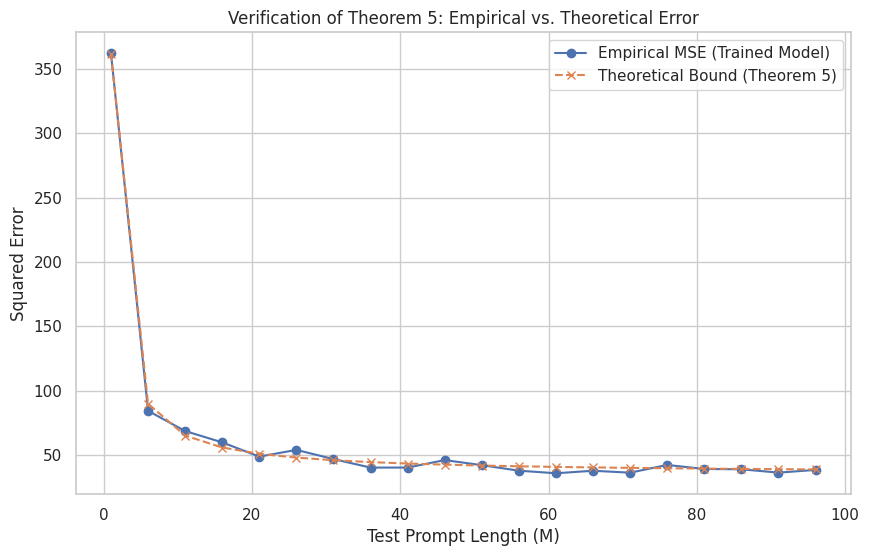

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# (Assume your trained model, d, N, Lambda are defined from previous code)

# Generate nonlinear test prompts for Theorem 5 (y = x^2 + sin(x) + noise)
def generate_nonlinear_prompt(M, d, Lambda, noise_std=0.1):
    X = np.random.multivariate_normal(np.zeros(d), Lambda, M+1)
    y = np.sum(X**2 + np.sin(X), axis=1) + noise_std * np.random.randn(M+1)  # Nonlinear
    E = np.vstack((X.T, np.append(y[:-1], 0)))  # (d+1, M+1)
    y_query = y[-1]
    x_query = X[-1]
    return torch.tensor(E, dtype=torch.float32, device=device), y_query, x_query

# Empirical MSE from trained model
def empirical_mse(model, M_values, d, Lambda, num_test=500):
    mses = {m: [] for m in M_values}
    for _ in range(num_test):
        for m in M_values:
            E, y_query, _ = generate_nonlinear_prompt(m, d, Lambda)
            pred = model(E).detach().cpu().item()
            mses[m].append((pred - y_query) ** 2)
    return {m: np.mean(err) for m, err in mses.items()}

# Theoretical bound from Theorem 5
def theoretical_bound(M_values, d, N, Lambda):
    Gamma = (1 + 1/N) * Lambda + (1/N) * np.trace(Lambda) * np.eye(d)
    Gamma_inv = np.linalg.inv(Gamma)

    # For nonlinear D: assume y = sum(x^2 + sin(x)) (expectations approximated via MC)
    num_samples = 10000
    X = np.random.multivariate_normal(np.zeros(d), Lambda, num_samples)
    y = np.sum(X**2 + np.sin(X), axis=1)
    E_xy = np.mean(y[:, np.newaxis] * X, axis=0)  # E[y x]
    a = np.linalg.inv(Lambda) @ E_xy  # a = Λ^{-1} E[y x]
    residuals = (y[:, np.newaxis] * X - E_xy)  # (y x - E[y x])
    Sigma = np.mean([np.outer(r, r) for r in residuals], axis=0)  # Σ

    # Min error (best linear predictor)
    min_error = np.mean((y - X @ a) ** 2)

    bounds = {}
    for M in M_values:
        term_M = (1/M) * np.trace(Sigma @ (Gamma_inv @ Gamma_inv) @ Lambda)
        term_N2 = (1/N**2) * (np.dot(a, (Gamma_inv @ Gamma_inv) @ Lambda @ Lambda @ Lambda @ a) +
                               2 * np.trace(Lambda) * np.dot(a, (Gamma_inv @ Gamma_inv) @ Lambda @ Lambda @ a) +
                               np.trace(Lambda)**2 * np.dot(a, (Gamma_inv @ Gamma_inv) @ Lambda @ a))
        bounds[M] = min_error + term_M + term_N2
    return bounds

# Plot comparison: Empirical MSE vs. Theoretical Bound
def plot_verification(M_values, empirical, theoretical):
    plt.figure(figsize=(10, 6))
    plt.plot(M_values, list(empirical.values()), label='Empirical MSE (Trained Model)', marker='o')
    plt.plot(M_values, list(theoretical.values()), label='Theoretical Bound (Theorem 5)', marker='x', linestyle='--')
    plt.xlabel('Test Prompt Length (M)')
    plt.ylabel('Mean Squared Error')
    plt.title('Verification of Theorem 5: Empirical vs. Theoretical Error')
    plt.legend()
    plt.grid(True)
    plt.savefig('theorem5_verification.png')
    plt.show()

# Run verification (extend your trained model)
M_values = list(range(1, 101, 5))  # Test M from 1 to 100

# Compute empirical MSE
empirical = empirical_mse(model, M_values, d, Lambda)

# Compute theoretical bound
theoretical = theoretical_bound(M_values, d, N, Lambda)

# Print sample comparisons
print("M | Empirical MSE | Theoretical Bound")
for m in M_values[:5]:  # Sample
    print(f"{m} | {empirical[m]:.4f} | {theoretical[m]:.4f}")

# Generate visualization
plot_verification(M_values, empirical, theoretical)


(btw one thing to note however function name saying bound but its not a bound)

**we can see in the plot above, MSE decreases with increasing M(test time test promt length) with N(train time promt length) = 1000, but here we can see the bound for some values is larger than experimental values but somewhere it's smaller, one reason for this might be, we are using only one promt per M value which might not be giving us true expectation everytime, let's increase promts per M and check what happens.**

**Let's vary promt per M and see**

done for promts_per_M=1
done for promts_per_M=10
done for promts_per_M=100
done for promts_per_M=1000
done for promts_per_M=10000


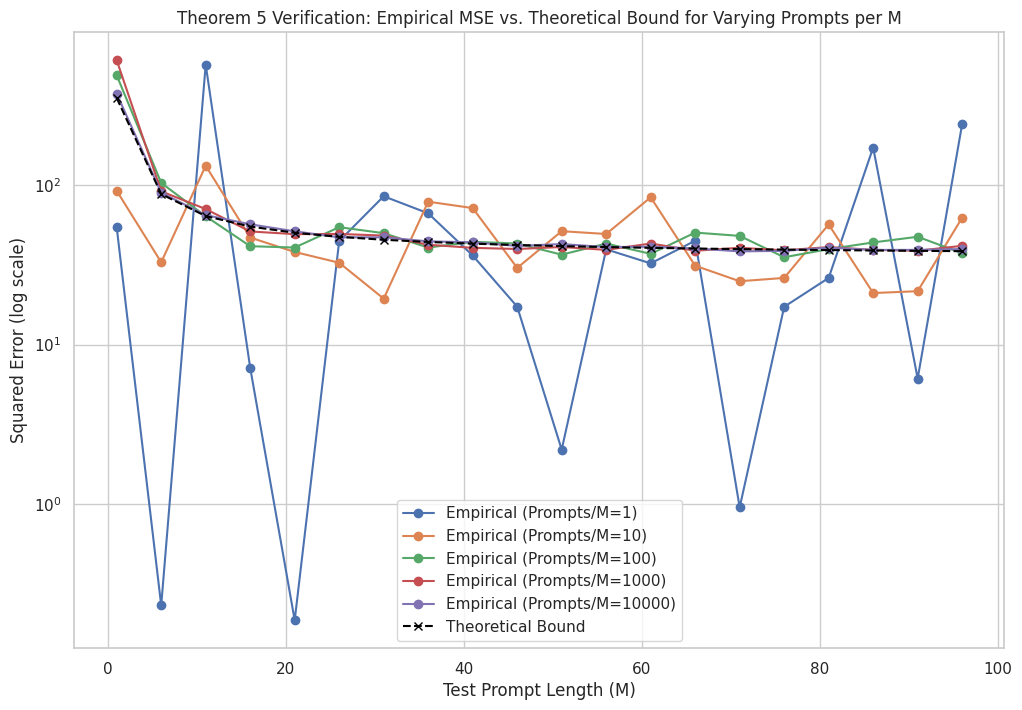

In [ ]:

# Empirical MSE (averaged over prompts_per_M for each M)
def empirical_mse(model, M_values, d, Lambda, prompts_per_M):
    mses = {m: [] for m in M_values}
    for m in M_values:
        for _ in range(prompts_per_M):
            E, y_query, _ = generate_nonlinear_prompt(m, d, Lambda)
            pred = model(E).detach().cpu().item()
            mses[m].append((pred - y_query) ** 2)
    print(f"done for promts_per_M={prompts_per_M}")
    return {m: np.mean(err) for m, err in mses.items()}

# Plot all variations in one figure
def plot_verification(M_values, empirical_dict, theoretical):
    plt.figure(figsize=(12, 8))
    for prompts in empirical_dict:
        plt.plot(M_values, list(empirical_dict[prompts].values()), label=f'Empirical (Prompts/M={prompts})', marker='o')
    plt.plot(M_values, list(theoretical.values()), label='Theoretical Bound', marker='x', linestyle='--', color='black')
    plt.yscale('log')  # Log scale for y-axis
    plt.xlabel('Test Prompt Length (M)')
    plt.ylabel('Squared Error (log scale)')
    plt.title('Theorem 5 Verification: Empirical MSE vs. Theoretical Bound for Varying Prompts per M')
    plt.legend()
    plt.grid(True)
    plt.savefig('theorem5_multi_verification.png')
    plt.show()

# Run verification
M_values = list(range(1, 101, 5))  # Test M from 1 to 100
prompts_per_M_list = [1, 10, 100, 1000, 10000]

empirical_dict = {}
for prompts_per_M in prompts_per_M_list:
    empirical_dict[prompts_per_M] = empirical_mse(model, M_values, d, Lambda, prompts_per_M)

theoretical = theoretical_bound(M_values, d, N, Lambda)

# Generate single plot with all variations
plot_verification(M_values, empirical_dict, theoretical)


done for promts_per_M=1
done for promts_per_M=10
done for promts_per_M=100
done for promts_per_M=1000
done for promts_per_M=10000


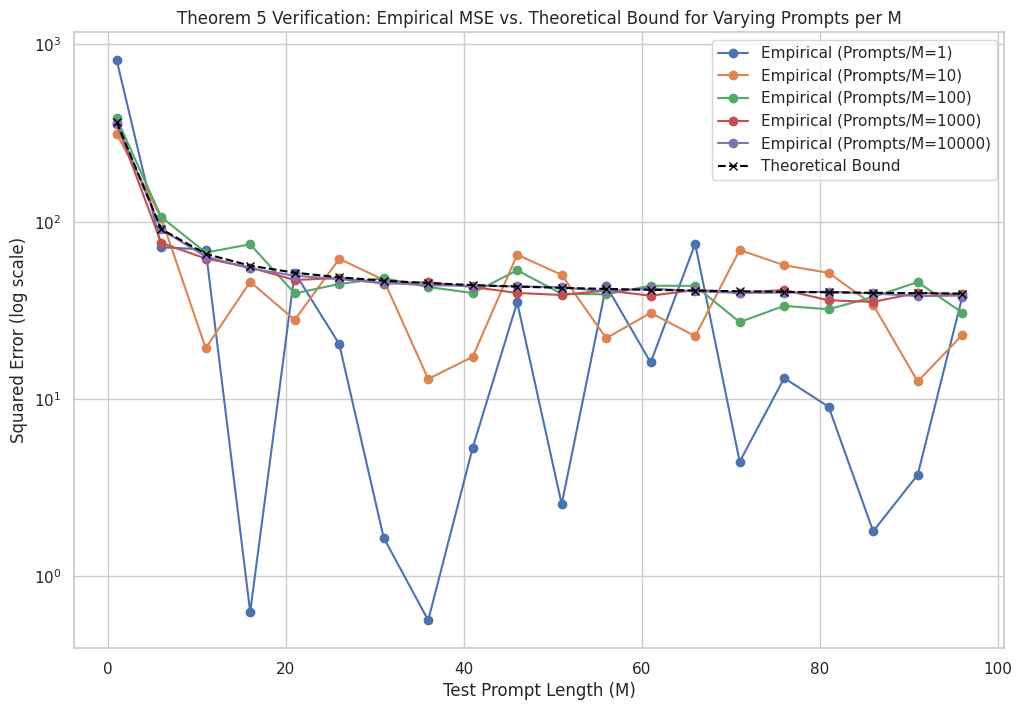

In [ ]:

# Empirical MSE (averaged over prompts_per_M for each M)
def empirical_mse(model, M_values, d, Lambda, prompts_per_M):
    mses = {m: [] for m in M_values}
    for m in M_values:
        for _ in range(prompts_per_M):
            E, y_query, _ = generate_nonlinear_prompt(m, d, Lambda)
            pred = model(E).detach().cpu().item()
            mses[m].append((pred - y_query) ** 2)
    print(f"done for promts_per_M={prompts_per_M}")
    return {m: np.mean(err) for m, err in mses.items()}

# Plot all variations in one figure
def plot_verification(M_values, empirical_dict, theoretical):
    plt.figure(figsize=(12, 8))
    for prompts in empirical_dict:
        plt.plot(M_values, list(empirical_dict[prompts].values()), label=f'Empirical (Prompts/M={prompts})', marker='o')
    plt.plot(M_values, list(theoretical.values()), label='Theoretical Bound', marker='x', linestyle='--', color='black')
    plt.yscale('log')  # Log scale for y-axis
    plt.xlabel('Test Prompt Length (M)')
    plt.ylabel('Squared Error (log scale)')
    plt.title('Theorem 5 Verification: Empirical MSE vs. Theoretical Bound for Varying Prompts per M')
    plt.legend()
    plt.grid(True)
    plt.savefig('theorem5_multi_verification.png')
    plt.show()

# Run verification
M_values = list(range(1, 101, 5))  # Test M from 1 to 100
prompts_per_M_list = [1, 10, 100, 1000, 10000]

empirical_dict = {}
for prompts_per_M in prompts_per_M_list:
    empirical_dict[prompts_per_M] = empirical_mse(model, M_values, d, Lambda, prompts_per_M)

theoretical = theoretical_bound(M_values, d, N, Lambda)

# Generate single plot with all variations
plot_verification(M_values, empirical_dict, theoretical)


# Bound

![image.png](attachment:f347305e-62a5-488c-b180-722b15256f4f.png)